In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pyrootutils
root = pyrootutils.setup_root(
    search_from='.',
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,
    dotenv=True,
)
os.chdir(root / "text_classification_problems")

In [3]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import re

# IMDb - Real Data

## Load evaluation result

### Non-cleanlab methods

In [4]:
imdb_real_train_path = Path("outputs/imdb/flip0_bert/")
output_dirs = '''121_2023-01-02_12-11-48
122_2023-01-02_12-11-48
123_2023-01-02_12-11-48
124_2023-01-02_12-12-57
125_2023-01-02_12-12-57'''
# imdb_real_train_path = Path("outputs/imdb/flip0.2_bert/")
# output_dirs = '''121_2023-01-03_19-26-09
# 122_2023-01-03_19-26-09
# 123_2023-01-03_19-26-09
# 124_2023-01-03_19-26-09
# 125_2023-01-03_19-26-09'''

def get_best_ckpt(checkpoint_dir: Path):
    metrics = [(float(re.search('val_acc=([+-]?([0-9]*[.])?[0-9]+)', str(p)).group(1)),p) for p in checkpoint_dir.glob("epoch*.ckpt")]
    metrics.sort(reverse=True)
    # metrics = [(float(re.search('epoch=([+-]?([0-9]*[.])?[0-9]+)', str(p)).group(1)),p) for p in checkpoint_dir.glob("epoch*.ckpt")]
    # metrics.sort(reverse=False)

    best_ckpt_path = metrics[0][1]
    return best_ckpt_path

avail_aggregation = ["KNN", "SC", "SA"]
avail_influence = ["GD", "GN", "GC", "IF"]

def extract_info_from_name(df):
    avail_aggregation = ["KNN", "SC", "SA"]
    avail_influence = ["GD", "GN", "GC", "IF"]
    def extract(s):
        method = s["method"].split("_")
        if len(method) == 1:
            return s
        s["aggregation"] = method[0] if method[0] in avail_aggregation else None
        s["influence"] = method[1] if method[1] in avail_influence else None
        s["k"] = int(method[-1]) if s["aggregation"] == "KNN" else None
        return s
    return df.apply(extract, axis=1)

def extract_info_from_name_row(s):
    method = s["method"].split("_")
    if len(method) == 1:
        return s
    s["aggregation"] = method[0] if method[0] in avail_aggregation else None
    s["influence"] = method[1] if method[1] in avail_influence else None
    s["k"] = int(method[-1]) if (s["aggregation"] == "KNN" and method[-1].isdigit())  else None
    return s

In [5]:
best_ckpt_results = []
for run in output_dirs.split('\n'):
    run = imdb_real_train_path / run
    best_ckpt_path = get_best_ckpt(run / "checkpoints")
    best_ckpt_result = pd.read_csv(str(best_ckpt_path) + ".csv")
    best_ckpt_result = best_ckpt_result.drop(columns="Unnamed: 0")
    best_ckpt_result["run"] = run.name
    best_ckpt_results.append(best_ckpt_result)
best_ckpt_results = pd.concat(best_ckpt_results, axis=0, ignore_index=True)
best_ckpt_results["method"] = best_ckpt_results["method"].apply(lambda x: "LengthGD" if x == "Length_GD" else x)
grouped_df = best_ckpt_results.groupby(["method"], as_index=False)

Group by `method` and take `min` aggregation.

In [6]:
mean_df = grouped_df.mean(numeric_only=True)
mean_df = extract_info_from_name(mean_df)
mean_df = mean_df.set_index("method")
mean_df.head(20)

,aggregation,influence,k,top100,top1000,top1050,top1100,top1150,top1200,top1250,...,top500,top550,top600,top650,top700,top750,top800,top850,top900,top950
method,,,,,,,,,,,,,,,,,,,,,
KNN_100,KNN,None,100.0,75.400001,56.860000,57.123810,56.472727,56.243477,55.650001,55.632000,...,68.760000,66.581819,63.999999,61.692308,60.171430,58.693334,57.525001,56.776471,56.533333,56.589473
KNN_1000,KNN,None,1000.0,81.200000,57.359998,57.333335,57.090908,56.556522,55.866667,55.616000,...,68.640000,67.090909,65.433333,64.153845,62.200000,60.799999,59.625000,58.635293,57.777778,57.242106
KNN_110,KNN,None,110.0,75.000000,56.820000,57.161905,56.454545,56.226087,55.633334,55.567999,...,68.640000,66.800002,63.666666,61.169230,59.857143,58.666667,57.975000,56.823530,56.600000,56.673684
KNN_120,KNN,None,120.0,76.200000,56.860001,57.219046,56.490909,56.243478,55.633334,55.616001,...,68.679999,66.763637,63.866665,61.353846,59.742856,58.986667,57.625000,56.870588,56.666666,56.715789
KNN_130,KNN,None,130.0,76.600000,56.860000,57.199998,56.563636,56.295652,55.666667,55.616001,...,68.720000,66.945455,64.066665,61.876923,60.714285,59.146668,58.000001,56.870588,56.622223,56.715789
KNN_140,KNN,None,140.0,73.600000,56.820002,57.180951,56.545454,56.278261,55.683334,55.600001,...,68.720000,67.018182,64.133332,61.969230,60.285715,59.039999,57.975000,56.964705,56.688888,56.736841
KNN_150,KNN,None,150.0,73.800000,56.899999,57.219046,56.672727,56.260870,55.750000,55.632000,...,68.680000,67.236365,64.333333,62.030768,60.685714,59.333334,58.224999,57.058823,56.666667,56.842105
KNN_160,KNN,None,160.0,74.000001,56.839999,57.200000,56.654545,56.260870,55.750000,55.600001,...,68.760000,67.163638,64.199998,62.061539,60.200000,58.959999,57.925000,57.011764,56.644446,56.821052
KNN_170,KNN,None,170.0,75.599999,56.900001,57.276189,56.672727,56.295652,55.766667,55.632001,...,68.920000,67.272729,64.366665,61.784616,59.914286,58.960000,58.175000,57.176471,56.688889,56.842105


### Cleanlab methods

In [7]:
CLEANLAB_METHODS = ['confidence_weighted_entropy', 'normalized_margin', 'self_confidence']
baseline_df = []
for m in CLEANLAB_METHODS:
  df = pd.read_csv( imdb_real_train_path / "baseline" /f"{m}.csv", sep="\t")
  df["top_size"] = df["top_size"].apply(lambda x: f"top{x}")
  df = df.set_index("top_size")
  df = df.mean(axis=1) * 100
  df["method"] = m
  baseline_df.append(df)
baseline_df = pd.concat(baseline_df, axis=1, ignore_index=True).T.rename_axis(None, axis="columns").set_index("method")
baseline_df = baseline_df.drop(columns=["top1310"])

In [8]:
baseline_df

,top50,top100,top150,top200,top250,top300,top350,top400,top450,top500,...,top850,top900,top950,top1000,top1050,top1100,top1150,top1200,top1250,top1300
method,,,,,,,,,,,,,,,,,,,,,
confidence_weighted_entropy,72.8,77.4,78.666667,78.4,76.72,74.733333,72.914286,71.85,71.422222,70.2,...,63.811765,62.866667,61.852632,61.02,60.209524,59.327273,58.556522,57.6,56.608,55.553846
normalized_margin,82.8,82.4,82.133333,80.9,78.88,76.466667,74.457143,73.1,72.488889,71.2,...,64.564706,63.644444,62.715789,61.74,60.761905,59.672727,58.747826,57.716667,56.768,55.630769
self_confidence,82.8,82.4,82.133333,80.9,78.88,76.466667,74.457143,73.1,72.488889,71.2,...,64.564706,63.644444,62.715789,61.74,60.761905,59.672727,58.747826,57.716667,56.768,55.630769


### Merge 

In [9]:
mean_df["is_cleanlab"] = False
baseline_df["is_cleanlab"] = True
mean_df = pd.concat((mean_df, baseline_df))

In [10]:
mean_df

,aggregation,influence,k,top100,top1000,top1050,top1100,top1150,top1200,top1250,...,top550,top600,top650,top700,top750,top800,top850,top900,top950,is_cleanlab
method,,,,,,,,,,,,,,,,,,,,,
KNN_100,KNN,None,100.0,75.400001,56.86,57.12381,56.472727,56.243477,55.650001,55.632,...,66.581819,63.999999,61.692308,60.17143,58.693334,57.525001,56.776471,56.533333,56.589473,False
KNN_1000,KNN,None,1000.0,81.2,57.359998,57.333335,57.090908,56.556522,55.866667,55.616,...,67.090909,65.433333,64.153845,62.2,60.799999,59.625,58.635293,57.777778,57.242106,False
KNN_110,KNN,None,110.0,75.0,56.82,57.161905,56.454545,56.226087,55.633334,55.567999,...,66.800002,63.666666,61.16923,59.857143,58.666667,57.975,56.82353,56.6,56.673684,False
KNN_120,KNN,None,120.0,76.2,56.860001,57.219046,56.490909,56.243478,55.633334,55.616001,...,66.763637,63.866665,61.353846,59.742856,58.986667,57.625,56.870588,56.666666,56.715789,False
KNN_130,KNN,None,130.0,76.6,56.86,57.199998,56.563636,56.295652,55.666667,55.616001,...,66.945455,64.066665,61.876923,60.714285,59.146668,58.000001,56.870588,56.622223,56.715789,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SC_GD,SC,GD,NaN,71.4,58.940001,58.076191,57.272726,56.782608,55.916667,55.84,...,67.709092,66.033335,65.076923,64.257144,62.906667,62.074999,60.964706,60.400001,59.36842,False
SC_GN,SC,GN,NaN,78.799999,58.639998,57.942858,57.399999,56.93913,56.383333,55.935999,...,67.745456,66.366668,65.076923,63.942858,63.04,62.175001,60.988235,60.222223,59.642106,False
confidence_weighted_entropy,NaN,NaN,NaN,77.4,61.02,60.209524,59.327273,58.556522,57.6,56.608,...,69.527273,68.633333,67.876923,67.0,66.106667,64.875,63.811765,62.866667,61.852632,True


## Comparations

Tạo bảng để visualize.  
Lưu ý ta lấy max theo `k` với KNN 

In [11]:
tmp_df = mean_df[mean_df.aggregation.notnull()]
tmp_df = tmp_df.groupby(["aggregation", "influence"], as_index=False, dropna=False).max()
tmp_df["method"] = tmp_df.apply(lambda r: r["aggregation"] + (f"_{r['influence']}" if not pd.isnull(r["influence"]) else ""), axis=1)
tmp_df = tmp_df.set_index("method")
tmp_df = pd.concat((tmp_df, mean_df[mean_df.aggregation.isnull()]))
tmp_df = tmp_df.drop(columns=["aggregation", "influence", "k", "is_cleanlab"])
tmp_df = tmp_df.T
tmp_df.index = tmp_df.index.map(lambda x: int(x[3:]))
tmp_df = tmp_df.reset_index().rename(columns={"index": "top"})


In [12]:
tmp_df.head(3)

method,top,KNN_GC,KNN_GD,KNN_GN,KNN,SA_GC,SA_GD,SA_GN,SC_GC,SC_GD,SC_GN,LengthGD,LossValue,confidence_weighted_entropy,normalized_margin,self_confidence
0,100,80.0,63.000001,79.599999,81.999999,79.0,70.799999,80.600001,78.399999,71.4,78.799999,79.2,81.2,77.4,82.4,82.4
1,1000,59.38,54.359999,55.319999,57.459999,59.299999,51.42,54.920002,58.7,58.940001,58.639998,59.88,59.78,61.02,61.74,61.74
2,1050,58.685714,54.476191,55.200001,57.52381,58.514285,51.409523,54.876192,57.980952,58.076191,57.942858,59.066666,58.971429,60.209524,60.761905,60.761905


In [13]:
tmp_df = tmp_df.melt('top', var_name='method', value_name='prec')
tmp_df = tmp_df.apply(extract_info_from_name_row, axis=1)
tmp_df['is_cleanlab'] = tmp_df["method"].apply(lambda x: x in CLEANLAB_METHODS)

In [14]:
tmp_df[tmp_df.is_cleanlab].head(10)

,aggregation,influence,k,method,prec,top,is_cleanlab
312,None,None,NaN,confidence_weighted_entropy,77.400000,100,True
313,None,None,NaN,confidence_weighted_entropy,61.020000,1000,True
314,None,None,NaN,confidence_weighted_entropy,60.209524,1050,True
315,None,None,NaN,confidence_weighted_entropy,59.327273,1100,True
316,None,None,NaN,confidence_weighted_entropy,58.556522,1150,True
317,None,None,NaN,confidence_weighted_entropy,57.600000,1200,True
318,None,None,NaN,confidence_weighted_entropy,56.608000,1250,True
319,None,None,NaN,confidence_weighted_entropy,55.553846,1300,True
320,None,None,NaN,confidence_weighted_entropy,78.666667,150,True
321,None,None,NaN,confidence_weighted_entropy,78.400000,200,True


In [15]:
tmp_df[~tmp_df.is_cleanlab].head(10)

,aggregation,influence,k,method,prec,top,is_cleanlab
0,KNN,GC,NaN,KNN_GC,80.000000,100,False
1,KNN,GC,NaN,KNN_GC,59.380000,1000,False
2,KNN,GC,NaN,KNN_GC,58.685714,1050,False
3,KNN,GC,NaN,KNN_GC,58.181818,1100,False
4,KNN,GC,NaN,KNN_GC,57.530434,1150,False
5,KNN,GC,NaN,KNN_GC,57.249999,1200,False
6,KNN,GC,NaN,KNN_GC,56.512001,1250,False
7,KNN,GC,NaN,KNN_GC,55.553846,1300,False
8,KNN,GC,NaN,KNN_GC,78.400000,150,False
9,KNN,GC,NaN,KNN_GC,77.600001,200,False


### Aggegration

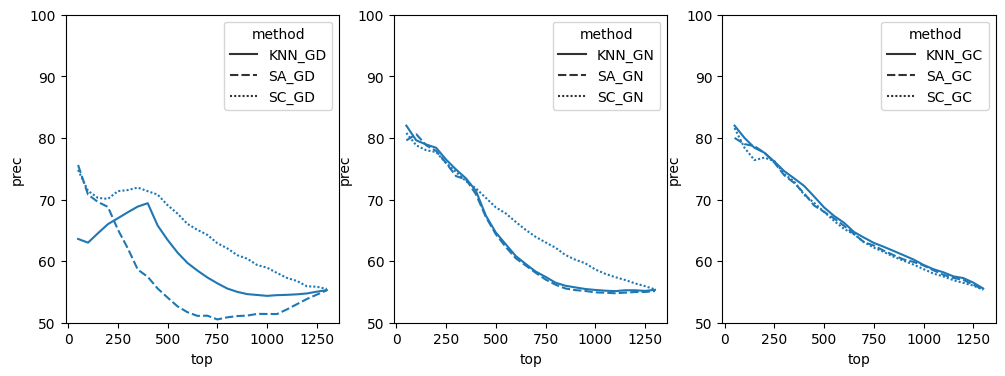

In [16]:
fig, axes = plt.subplots(1,3, figsize=(12, 4))
sns.lineplot(data=tmp_df[tmp_df["influence"] == "GD"], x="top", y="prec", style="method", ax=axes[0])
sns.lineplot(data=tmp_df[tmp_df["influence"] == "GN"], x="top", y="prec", style="method", ax=axes[1])
sns.lineplot(data=tmp_df[tmp_df["influence"] == "GC"], x="top", y="prec", style="method", ax=axes[2])
for ax in axes:
    ax.set_ylim((50,100))

### Influence

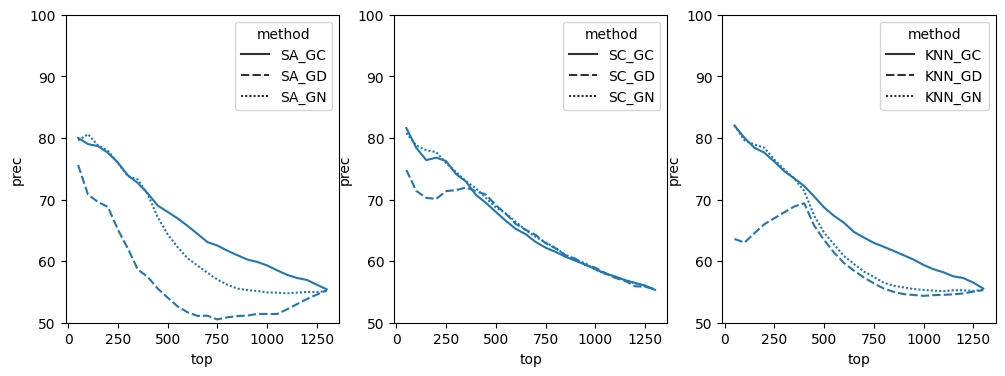

In [17]:
fig, axes = plt.subplots(1,3, figsize=(12, 4))
sns.lineplot(data=tmp_df[tmp_df["aggregation"] == "SA"], x="top", y="prec", style="method", ax=axes[0])
sns.lineplot(data=tmp_df[tmp_df["aggregation"] == "SC"], x="top", y="prec", style="method", ax=axes[1]) 
sns.lineplot(data=tmp_df[tmp_df["aggregation"] == "KNN"], x="top", y="prec", style="method", ax=axes[2])
for ax in axes:
    ax.set_ylim((50,100))

### Compare with baseline 1 (cleanlab methods)

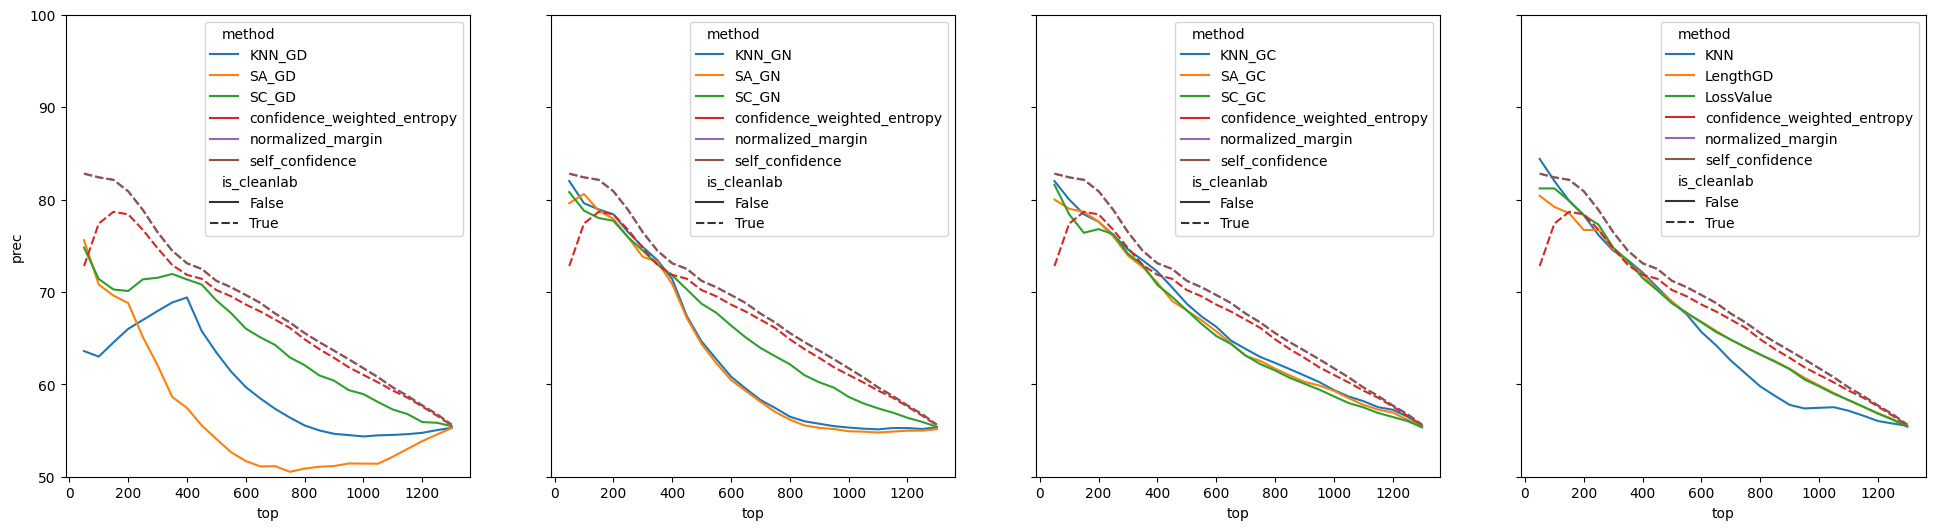

In [18]:
fig, axes = plt.subplots(1,4, figsize=(24, 6), sharey="all")
sns.lineplot(data=tmp_df[(tmp_df["influence"] == "GD") | tmp_df.is_cleanlab], x="top", y="prec", hue="method", style="is_cleanlab", ax=axes[0])
sns.lineplot(data=tmp_df[(tmp_df["influence"] == "GN") | tmp_df.is_cleanlab], x="top", y="prec", hue="method", style="is_cleanlab", ax=axes[1])
sns.lineplot(data=tmp_df[(tmp_df["influence"] == "GC") | tmp_df.is_cleanlab], x="top", y="prec", hue="method", style="is_cleanlab", ax=axes[2])
sns.lineplot(data=tmp_df[tmp_df["influence"].isnull() | tmp_df.is_cleanlab], x="top", y="prec", hue="method", style="is_cleanlab", ax=axes[3])
for ax in axes:
    ax.set_ylim((50,100))

### KNN

/tmp/ipykernel_1077221/3270214560.py:3: FutureWarning: The default value of numeric_only in DataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  opt_result = mean_df.max(axis=0).drop(index=["k", "is_cleanlab"])
/tmp/ipykernel_1077221/3270214560.py:3: FutureWarning: The default value of numeric_only in DataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  opt_result = mean_df.max(axis=0).drop(index=["k", "is_cleanlab"])
/tmp/ipykernel_1077221/3270214560.py:3: FutureWarning: The default value of numeric_only in DataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select 

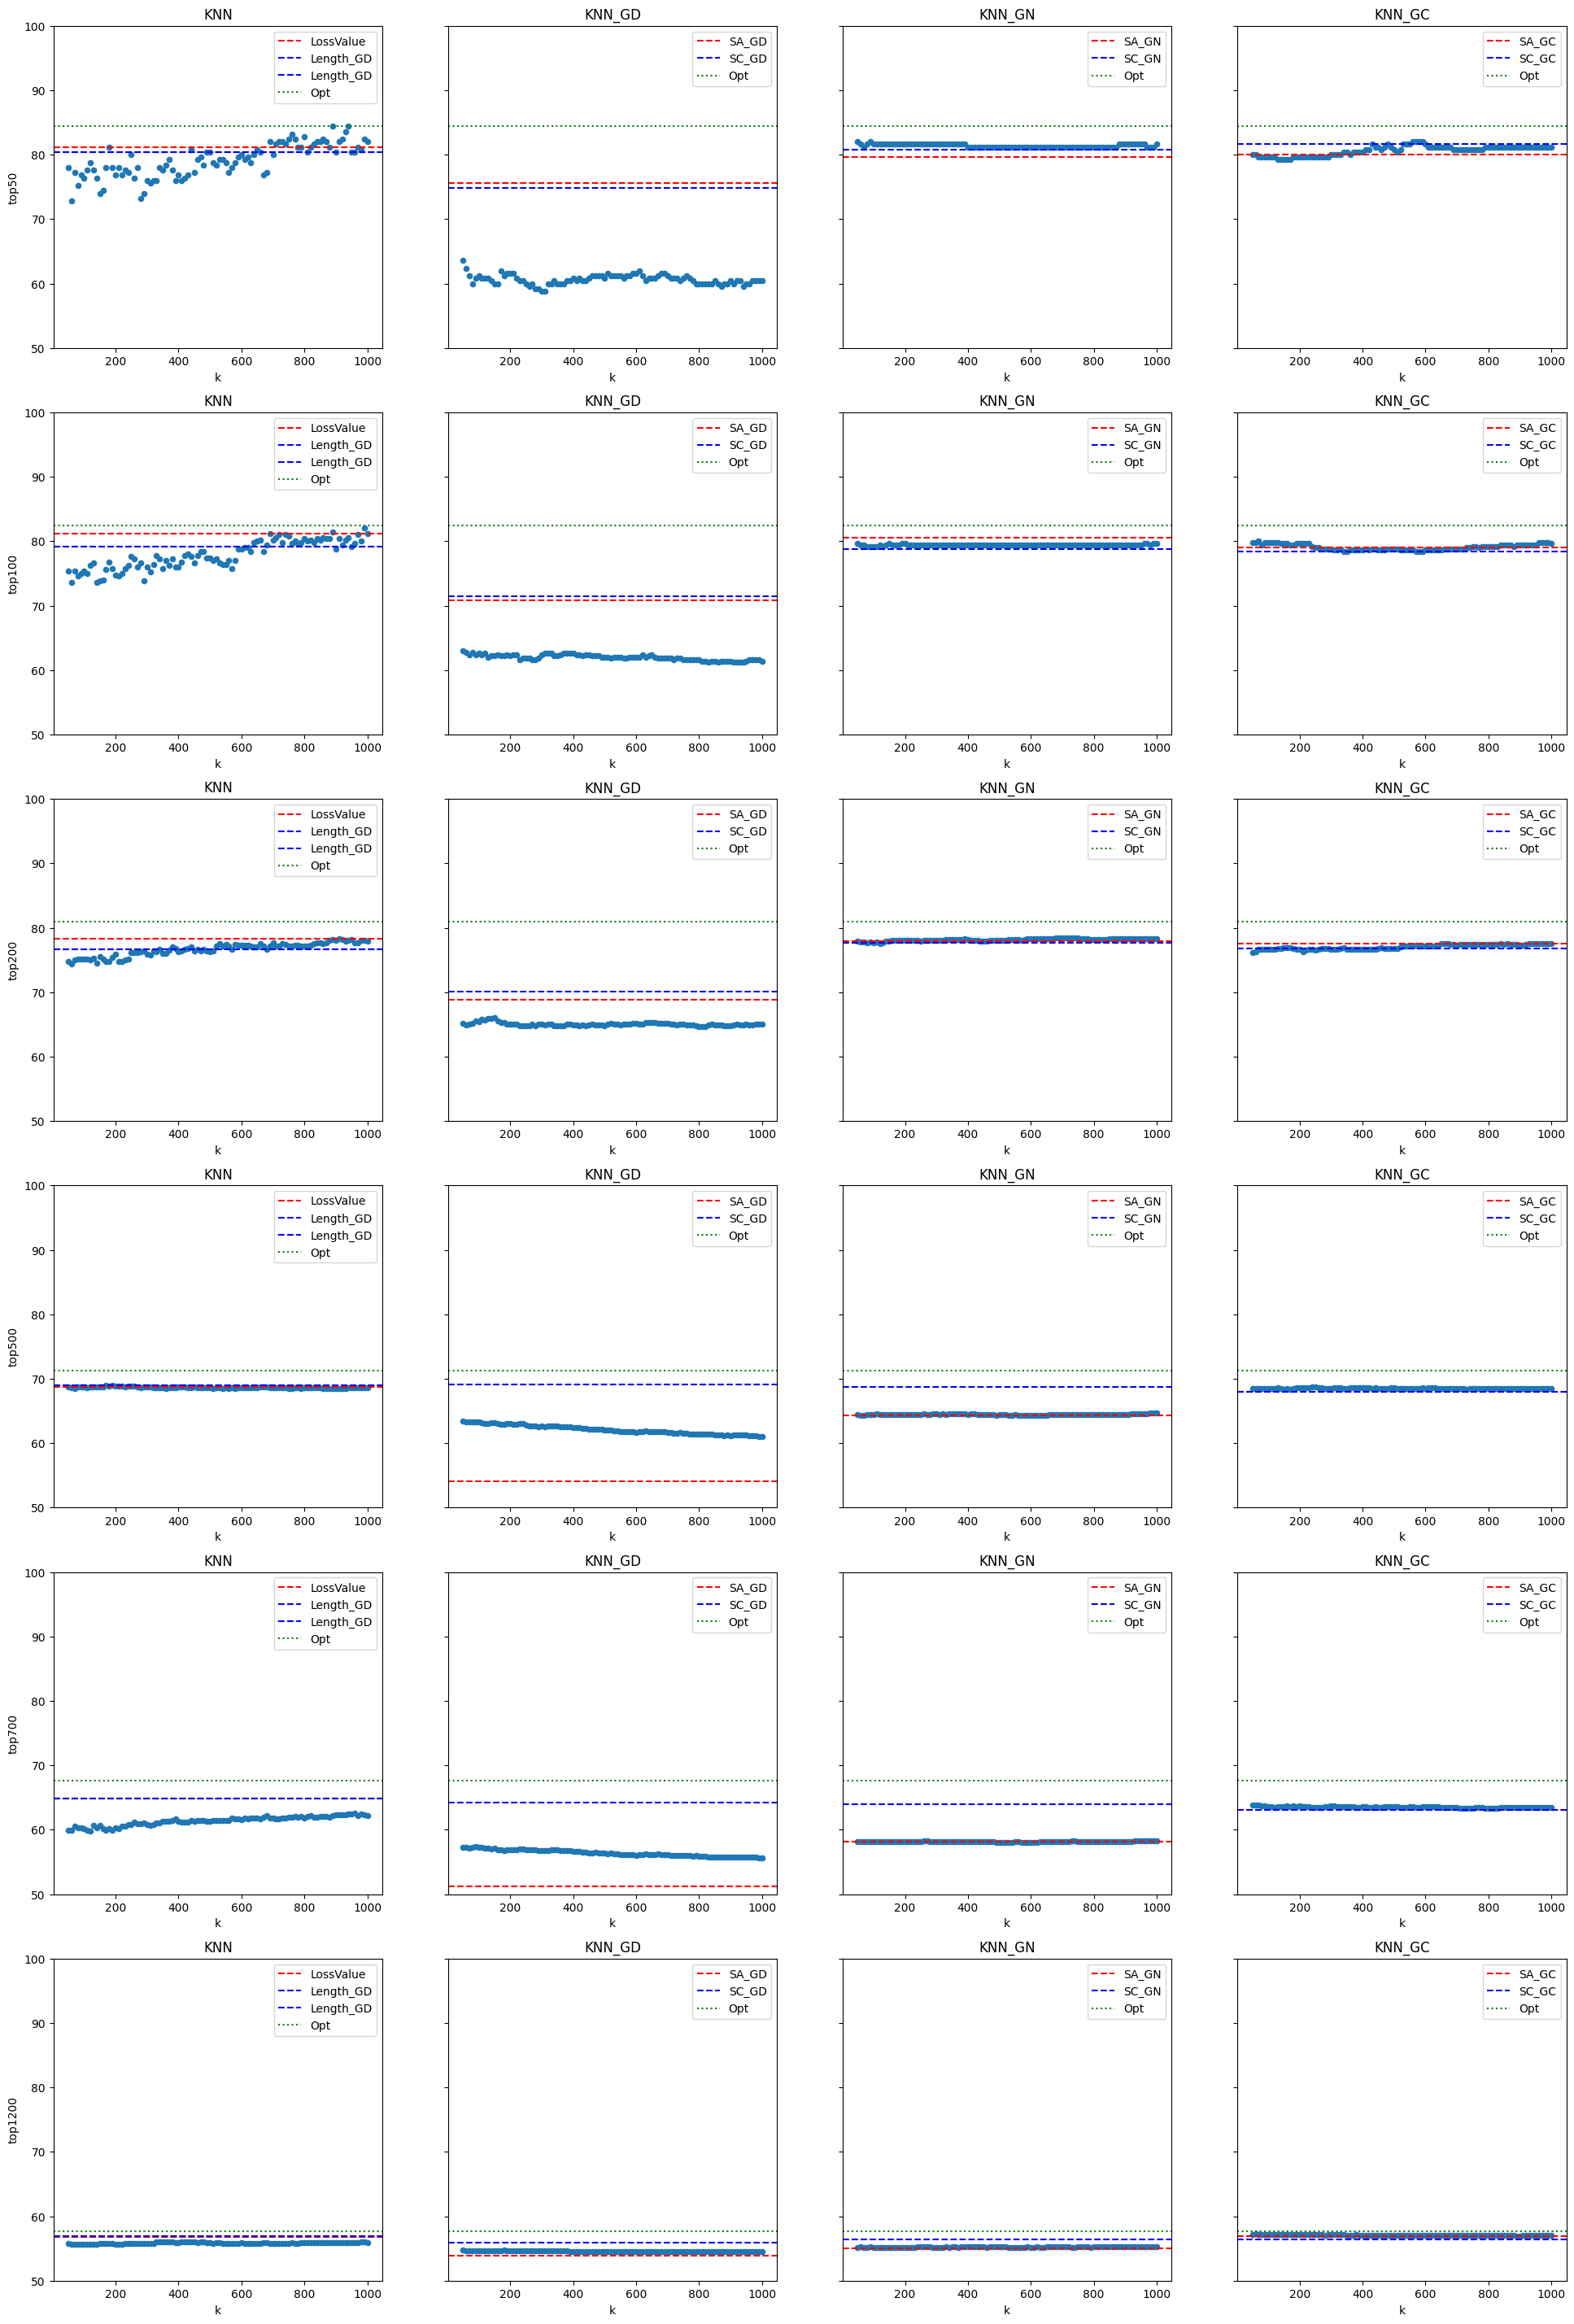

In [19]:
def plot_knn_1(top_plot, axes):
    mean_df[(mean_df.aggregation == "KNN") & (mean_df.influence.isnull())].sort_values(by=top_plot, ascending=False).plot.scatter(x="k", y=top_plot, ax=axes[0])
    opt_result = mean_df.max(axis=0).drop(index=["k", "is_cleanlab"])

    axes[0].set_title("KNN")
    axes[0].axhline(y = mean_df.loc["LossValue", top_plot], color = 'r', linestyle = 'dashed', label="LossValue")
    axes[0].axhline(y = mean_df.loc["LengthGD", top_plot], color = 'b', linestyle = 'dashed', label="Length_GD")
    axes[0].axhline(y = mean_df.loc["LengthGD", top_plot], color = 'b', linestyle = 'dashed', label="Length_GD")
    axes[0].axhline(y = opt_result[top_plot], color = 'g', linestyle = ':', label="Opt")
    axes[0].legend(loc = 'upper right')

    mean_df[(mean_df.aggregation == "KNN") & (mean_df.influence == "GD")].sort_values(by=top_plot, ascending=False).plot.scatter(x="k", y=top_plot, ax=axes[1])
    axes[1].set_title("KNN_GD")
    axes[1].axhline(y = mean_df.loc["SA_GD", top_plot], color = 'r', linestyle = 'dashed', label="SA_GD")
    axes[1].axhline(y = mean_df.loc["SC_GD", top_plot], color = 'b', linestyle = 'dashed', label="SC_GD")
    axes[1].axhline(y = opt_result[top_plot], color = 'g', linestyle = ':', label="Opt")
    axes[1].legend(loc = 'upper right')

    mean_df[(mean_df.aggregation == "KNN") & (mean_df.influence == "GN")].sort_values(by=top_plot, ascending=False).plot.scatter(x="k", y=top_plot, ax=axes[2])
    axes[2].set_title("KNN_GN")
    axes[2].axhline(y = mean_df.loc["SA_GN", top_plot], color = 'r', linestyle = 'dashed', label="SA_GN")
    axes[2].axhline(y = mean_df.loc["SC_GN", top_plot], color = 'b', linestyle = 'dashed', label="SC_GN")
    axes[2].axhline(y = opt_result[top_plot], color = 'g', linestyle = ':', label="Opt")
    axes[2].legend(loc = 'upper right')

    mean_df[(mean_df.aggregation == "KNN") & (mean_df.influence == "GC")].sort_values(by=top_plot, ascending=False).plot.scatter(x="k", y=top_plot, ax=axes[3])
    axes[3].set_title("KNN_GC")
    axes[3].axhline(y = mean_df.loc["SA_GC", top_plot], color = 'r', linestyle = 'dashed', label="SA_GC")
    axes[3].axhline(y = mean_df.loc["SC_GC", top_plot], color = 'b', linestyle = 'dashed', label="SC_GC")
    axes[3].axhline(y = opt_result[top_plot], color = 'g', linestyle = ':', label="Opt")
    axes[3].legend(loc = 'upper right')

    for ax in axes:
        ax.set_ylim((50,100))

fig, axes = plt.subplots(6, 4, figsize=(6*4, 6*6), sharey="row")
plot_knn_1("top50", axes[0])
plot_knn_1("top100", axes[1])
plot_knn_1("top200", axes[2])
plot_knn_1("top500", axes[3])
plot_knn_1("top700", axes[4])
plot_knn_1("top1200", axes[5])